In [1]:
import pandas as pd
import numpy as np

# Load and rename
meta = pd.read_csv("meta.csv")
meta = meta.rename(columns={
    'cases.submitter_id': 'id',
    'demographic.age_at_index': 'age',
    'demographic.gender': 'sex',
    'diagnoses.tumor_grade': 'grade',
    'diagnoses.primary_diagnosis': 'gt',
    'demographic.days_to_death': 'death',
    "demographic.vital_status": "mortality",
    "treatments.treatment_type": "treatment"
})

# Clean ID column
meta['id'] = meta['id'].str.strip().str.upper()

print("Original shape:", meta.shape)
print("Duplicated IDs:", meta['id'].duplicated().sum())

# Merge by taking first non-null value per column in each ID group
meta = meta.groupby('id').agg(lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan).reset_index()

print("Shape after merging duplicates:", meta.shape)


Original shape: (4916, 45)
Duplicated IDs: 3687
Shape after merging duplicates: (1229, 45)


In [2]:
print("Number of duplicated IDs:", meta['id'].duplicated().sum())
print("Unique IDs:", meta['id'].nunique())
print("Total rows:", meta.shape[0])


Number of duplicated IDs: 0
Unique IDs: 1229
Total rows: 1229


In [3]:
meta.head()

,id,demographic.days_to_birth,death,age,diagnoses.age_at_diagnosis,gt,grade,sex,mortality,treatment,...,"treatment_type_Radiation, External Beam_onehot","treatment_type_Pharmaceutical Therapy, NOS_onehot","treatment_type_Surgery, NOS_onehot","treatment_type_Radiation, Cyberknife_onehot","treatment_type_Radiation, Stereotactic/Gamma Knife/SRS_onehot","treatment_type_Radiation, Intensity-Modulated Radiotherapy_onehot","treatment_type_Brachytherapy, NOS_onehot",treatment_type_Antiseizure Treatment_onehot,treatment_type_Steroid Therapy_onehot,"treatment_type_Radiation, Radioisotope_onehot"
0,C1230738,NaN,640.0,53.0,NaN,Glioblastoma,G4,female,Dead,NaN,...,0,0,0,0,0,0,0,0,0,0
1,C1245129,NaN,598.0,43.0,NaN,Glioblastoma,G4,male,Dead,NaN,...,0,0,0,0,0,0,0,0,0,0
2,C204057,NaN,351.0,65.0,NaN,Glioblastoma,G4,female,Dead,NaN,...,0,0,0,0,0,0,0,0,0,0
3,C207624,NaN,733.0,55.0,NaN,Glioblastoma,G4,female,Dead,NaN,...,0,0,0,0,0,0,0,0,0,0
4,C208854,NaN,253.0,67.0,NaN,Glioblastoma,G4,male,Dead,NaN,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Create a new 'age_combined' column using age or fallback to age_at_diagnosis
meta['age'] = meta['age'].combine_first(meta['diagnoses.age_at_diagnosis'])
meta['age'] = meta['age'].combine_first(meta['demographic.days_to_birth'])

# Drop the now redundant 'diagnoses.age_at_diagnosis'
meta = meta.drop(columns=['diagnoses.age_at_diagnosis'])
meta = meta.drop(columns=['demographic.days_to_birth'])

In [5]:
# Keep only IDs starting with 'TCGA', 'UPENN', or 'C3'
meta = meta[meta['id'].str.startswith(('TCGA', 'UPENN', 'C3'))]

print("Shape after filtering by ID prefix:", meta.shape)


Shape after filtering by ID prefix: (1198, 43)


In [6]:
meta = meta.dropna(subset=['age', 'death', 'grade'], how='all')

print("Shape after dropping rows missing all of age, death, and grade:", meta.shape)


Shape after dropping rows missing all of age, death, and grade: (1193, 43)


In [7]:
# If you haven't renamed 'demographic.vital_status', use the original column name
# Otherwise, replace 'vital_status' with your actual column name

meta.loc[meta['mortality'] == 'Alive', 'death'] = 9999


In [8]:

# Fix gt containing glioblastoma (case-insensitive, allowing minor typos)
mask = meta['gt'].str.contains('glioblastoma', case=False, na=False)


# Set grade to G4 where mask is True
meta.loc[mask, 'grade'] = 'G4'

# Correct spelling in gt
meta.loc[mask, 'gt'] = 'Glioblastoma'


# Standardize the glioma type values
meta['gt'] = meta['gt'].str.lower()  # lowercase for consistent matching

# Apply mapping
meta['gt'] = meta['gt'].apply(lambda x: 'Oligodendroglioma' if isinstance(x, str) and 'oligo' in x else x)
meta['gt'] = meta['gt'].apply(lambda x: 'Astrocytoma' if isinstance(x, str) and 'astro' in x else x)



In [9]:
missing_age = meta['gt'].isna().sum()
print(f"Remaining missing values in 'age': {missing_age}")

Remaining missing values in 'age': 17


In [10]:
meta= meta.replace(
    to_replace=r'(?i)^not reported$',  # regex: case-insensitive exact match "not reported"
    value=np.nan,
    regex=True
)
meta= meta.replace(
    to_replace=r'(?i)^unknown$',  # regex: case-insensitive exact match "not reported"
    value=np.nan,
    regex=True
)


In [17]:
meta.loc[meta['grade'] == 'G4', 'gt'] = 'Glioblastoma'


# Fill age and death using mean by glioma type
meta['age'] = meta.groupby('gt')['age'].transform(lambda x: x.fillna(x.mean()))
meta['death'] = meta.groupby('gt')['death'].transform(lambda x: x.fillna(x.mean()))

# First attempt to fill grade by gt
meta['grade'] = meta.groupby('gt')['grade'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
)

# Step 2: Fill remaining missing by 'mortality' — only if still NaN
mask_missing = meta['grade'].isna()

meta.loc[mask_missing, 'grade'] = (
    meta[mask_missing]
    .groupby('mortality')['grade']
    .transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
)

# First attempt to fill grade by gt
meta['mortality'] = meta.groupby('gt')['mortality'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
)

In [12]:
# Find the most frequent value in 'sex' column (ignoring NaNs)
majority_sex = meta['sex'].mode()[0]

# Fill missing values with the majority
meta['sex'] = meta['sex'].fillna(majority_sex)

print(f"Filled missing 'sex' values with majority: {majority_sex}")


Filled missing 'sex' values with majority: male


In [13]:
# Define columns to retain
columns_to_keep = [
    'id',
    'death',
    'age',
    'gt',
    'grade',
    'sex',
    'mortality',
    'treatment'
]

# Filter the DataFrame
meta = meta[columns_to_keep]

# Save to CSV


In [14]:
meta = meta.dropna(subset=['age', 'death', 'grade'], how='all')

# Show rows where 'age' is missing
missing_age_rows = meta[meta['grade'].isna()]

print(f"Number of rows with missing age: {len(missing_age_rows)}")
display(missing_age_rows)


Number of rows with missing age: 2


,id,death,age,gt,grade,sex,mortality,treatment
1001,TCGA-FG-A713,9999.0,74.0,"basal cell carcinoma, nos",NaN,female,Alive,"Surgery, NOS"
1086,TCGA-HW-7490,9999.0,41.0,"papillary carcinoma, nos",NaN,male,Alive,"Radiation Therapy, NOS"


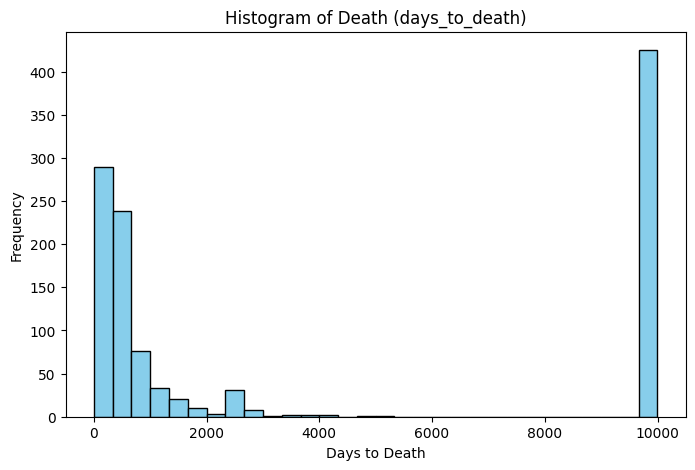

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

# Using matplotlib
plt.hist(meta['death'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Death (days_to_death)')
plt.xlabel('Days to Death')
plt.ylabel('Frequency')
plt.show()


In [16]:
meta.to_csv("meta_final_cleaned.csv", index=False)
